https://lifetechia.com/vlm-lens-vision-language-model-analysis/

In [1]:
!git clone https://github.com/compling-wat/vlm-lens.git
%cd vlm-lens

fatal: destination path 'vlm-lens' already exists and is not an empty directory.
/content/vlm-lens


In [2]:
!pip install virtualenv
!pip install PyYAML

In [3]:
!virtualenv --no-download "venv/vlm-lens-base" --prompt "vlm-lens-base"  # Or "python3.10 -m venv venv/vlm-lens-base"
!source venv/vlm-lens-base/bin/activate

created virtual environment CPython3.12.12.final.0-64 in 405ms
  creator CPython3Posix(dest=/content/vlm-lens/venv/vlm-lens-base, clear=False, no_vcs_ignore=False, global=False)
  seeder FromAppData(download=False, pip=bundle, via=copy, app_data_dir=/root/.local/share/virtualenv)
    added seed packages: pip==24.3.1
  activators BashActivator,CShellActivator,FishActivator,NushellActivator,PowerShellActivator,PythonActivator


In [4]:
!pip install --upgrade pip
!pip install -r envs/base/requirements.txt

vml-lensは制御をyamlファイルで制御している。

### yamlの内容
architecture: 使用するVLMのアーキテクチャを指定します (例: blip2, clip, llava)。
model_path: モデルのパスを指定します。Hugging Face Hubからモデルをダウンロードする場合は、リポジトリ名を指定します。
model: モデルのロードに関する設定を行います。torch_dtype: autoは、自動的に適切なデータ型を選択することを意味します。
output_db: 抽出されたデータを保存するSQLite3データベースのパスを指定します。
input_dir: 入力画像が格納されているディレクトリを指定します。
prompt: VLMに入力するテキストプロンプトを指定します。
modules: 抽出するVLMのモジュール（レイヤー）を指定します。--log-named-modulesオプションを使用すると、モデルのレイヤー構造を確認できます。

In [6]:
import yaml

# YAMLに書き出す内容をPythonの辞書で表現
data = {
    'architecture': 'blip2',
    'model_path': 'Salesforce/blip2-opt-2.7b',
    'model': {
        'torch_dtype': 'auto'
    },
    'output_db': 'output/blip2.db',
    'input_dir': './data/test-images/',
    'prompt': 'Describe the color in this image in one word.',
    'modules': [
        'language_model.lm_head',
        'vision_model.post_layernorm'
    ]
}

# ファイル名
filename = 'config_blip.yaml'

# ファイルに書き出す
with open(filename, 'w') as file:
    yaml.dump(data, file, sort_keys=False) # sort_keys=Falseで元の順序を維持

print(f"'{filename}'が作成されました。")

# 作成されたファイルの内容を確認
with open(filename, 'r') as file:
    print("\n--- ファイル内容 ---")
    print(file.read())

'config_blip.yaml'が作成されました。

--- ファイル内容 ---
architecture: blip2
model_path: Salesforce/blip2-opt-2.7b
model:
  torch_dtype: auto
output_db: output/blip2.db
input_dir: /data/test-images/
prompt: Describe the color in this image in one word.
modules:
- language_model.lm_head
- vision_model.post_layernorm



https://pytorch.org/get-started/previous-versions/

もし、pytorch、torchvisionのバージョンがあってない場合、上記サイトを確認してインストールしなおす必要がある。

インストールすべきバージョンは使っているcudaをもとに選択する。

cudaのバージョンは以下で確認する。

In [15]:
!nvidia-smi

Sat Oct 18 22:47:55 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   42C    P8             11W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [13]:
!pip uninstall -y torch torchvision
!pip install torch==2.8.0 torchvision==0.23.0 torchaudio==2.8.0

Found existing installation: torch 2.6.0
Uninstalling torch-2.6.0:
  Successfully uninstalled torch-2.6.0
Found existing installation: torchvision 0.23.0+cu126
Uninstalling torchvision-0.23.0+cu126:
  Successfully uninstalled torchvision-0.23.0+cu126


コマンド実行。

実行結果はyamlに指定したデータベースに格納される。

In [19]:
!python -m src.main --config /content/vlm-lens/configs/models/blip2/blip2-opt-2.7b.yaml

2025-10-18 22:55:24.526062: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1760828124.546935    9558 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760828124.553763    9558 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1760828124.571192    9558 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1760828124.571220    9558 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1760828124.571224    9558 computation_placer.cc:177] computation placer alr

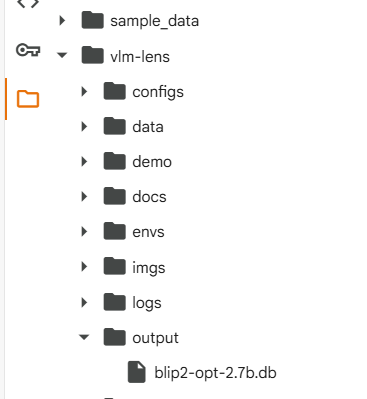

| 列名             | 内容                | 例                                                 |
| -------------- | ----------------- | ------------------------------------------------- |
| `id`           | 実験・記録の通し番号        | 1, 2, 3, ...                                      |
| `name`         | モデル名              | `Salesforce/blip2-opt-2.7b`                       |
| `architecture` | モデルの種類            | `blip2`, `llava`, など                              |
| `timestamp`    | 実行時刻              | `2025-10-18 23:04:24`                             |
| `image_path`   | 処理対象の画像パス         | `/content/vlm-lens/data/test-images/...`          |
| `prompt`       | 入力プロンプト           | `"Describe the color in this image in one word."` |
| `layer`        | どの層のテンソルを取得したか    | `vision_model.post_layernorm`など                   |
| `tensor_dim`   | ベクトルの次元数          | 1408 や 50304                                      |
| `tensor`       | 実際の中間表現（埋め込みベクトル） | バイナリ圧縮データ（b'PK\x03...'）                           |


In [24]:
import sqlite3
import pandas as pd

# データベースファイルのパス
db_path = '/content/vlm-lens/output/blip2-opt-2.7b.db'

# SQLiteデータベースに接続
conn = sqlite3.connect(db_path)

# データベースの全データをDataFrameに読み込む
df = pd.read_sql_query("SELECT * FROM tensors;", conn)

# 接続を閉じる
conn.close()

# データの表示
print("DataFrameの先頭5行:")
print(df.head())
print("\nDataFrameの情報を表示:")
print(df.info())

DataFrameの先頭5行:
   id                       name architecture            timestamp  \
0   1  Salesforce/blip2-opt-2.7b        blip2  2025-10-18 23:04:24   
1   2  Salesforce/blip2-opt-2.7b        blip2  2025-10-18 23:04:24   
2   3  Salesforce/blip2-opt-2.7b        blip2  2025-10-18 23:04:24   
3   4  Salesforce/blip2-opt-2.7b        blip2  2025-10-18 23:04:25   
4   5  Salesforce/blip2-opt-2.7b        blip2  2025-10-18 23:04:25   

                                          image_path image_id  \
0  /content/vlm-lens/data/test-images/black_in_bl...     None   
1  /content/vlm-lens/data/test-images/black_in_bl...     None   
2  /content/vlm-lens/data/test-images/black_in_bl...     None   
3  /content/vlm-lens/data/test-images/black_in_bl...     None   
4  /content/vlm-lens/data/test-images/black_in_bl...     None   

                                          prompt label  \
0  Describe the color in this image in one word.  None   
1  Describe the color in this image in one word.  None  

In [26]:
df.head()

,id,name,architecture,timestamp,image_path,image_id,prompt,label,layer,pooling_method,tensor_dim,tensor,decoded_tensor
0,1,Salesforce/blip2-opt-2.7b,blip2,2025-10-18 23:04:24,/content/vlm-lens/data/test-images/black_in_bl...,None,Describe the color in this image in one word.,None,vision_model.post_layernorm,None,1408,b'PK\x03\x04\x00\x00\x08\x08\x00\x00\x00\x00\x...,None
1,2,Salesforce/blip2-opt-2.7b,blip2,2025-10-18 23:04:24,/content/vlm-lens/data/test-images/black_in_bl...,None,Describe the color in this image in one word.,None,vision_model.post_layernorm,None,1408,b'PK\x03\x04\x00\x00\x08\x08\x00\x00\x00\x00\x...,None
2,3,Salesforce/blip2-opt-2.7b,blip2,2025-10-18 23:04:24,/content/vlm-lens/data/test-images/black_in_bl...,None,Describe the color in this image in one word.,None,language_model.lm_head,None,50304,b'PK\x03\x04\x00\x00\x08\x08\x00\x00\x00\x00\x...,None
3,4,Salesforce/blip2-opt-2.7b,blip2,2025-10-18 23:04:25,/content/vlm-lens/data/test-images/black_in_bl...,None,Describe the color in this image in one word.,None,vision_model.post_layernorm,None,1408,b'PK\x03\x04\x00\x00\x08\x08\x00\x00\x00\x00\x...,None
4,5,Salesforce/blip2-opt-2.7b,blip2,2025-10-18 23:04:25,/content/vlm-lens/data/test-images/black_in_bl...,None,Describe the color in this image in one word.,None,vision_model.post_layernorm,None,1408,b'PK\x03\x04\x00\x00\x08\x08\x00\x00\x00\x00\x...,None


In [25]:
import pandas as pd
import numpy as np
import pickle
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


# --- tensor列のバイナリをデコード ---
def decode_tensor(blob):
    try:
        # b'PK...' は zip圧縮されている場合が多い
        return pickle.loads(blob)
    except Exception:
        return None

df["decoded_tensor"] = df["tensor"].apply(lambda x: decode_tensor(eval(x)) if isinstance(x, str) else None)

# --- Noneを除外 ---
valid_df = df[df["decoded_tensor"].notnull()]

# --- 1次元配列化 ---
X = np.stack(valid_df["decoded_tensor"].to_numpy())

# --- PCAで2次元に圧縮 ---
pca = PCA(n_components=2)
X_2d = pca.fit_transform(X)

# --- 可視化 ---
plt.figure(figsize=(6,6))
plt.scatter(X_2d[:,0], X_2d[:,1])
plt.title("VLM-LENS Layer Embedding Distribution")
plt.xlabel("PCA1")
plt.ylabel("PCA2")
plt.show()

ValueError: need at least one array to stack

In [31]:
df["decoded_tensor"] = df["tensor"].apply(decode_tensor)
df["tensor"]

,tensor
0,b'PK\x03\x04\x00\x00\x08\x08\x00\x00\x00\x00\x...
1,b'PK\x03\x04\x00\x00\x08\x08\x00\x00\x00\x00\x...
2,b'PK\x03\x04\x00\x00\x08\x08\x00\x00\x00\x00\x...
3,b'PK\x03\x04\x00\x00\x08\x08\x00\x00\x00\x00\x...
4,b'PK\x03\x04\x00\x00\x08\x08\x00\x00\x00\x00\x...
5,b'PK\x03\x04\x00\x00\x08\x08\x00\x00\x00\x00\x...


In [47]:
import io, zipfile, numpy as np

def decode_tensor_from_bytes(b):
    try:
        with zipfile.ZipFile(io.BytesIO(b)) as zf:
            print("ZIP contents:", zf.namelist())  # ← 一度中身を確認
            for name in zf.namelist():
                if name.endswith(".npy"):
                    with zf.open(name) as f:
                        return np.load(f)
    except Exception as e:
        print("decode error:", e)
        return None

df["decoded_tensor"] = df["tensor"].apply(decode_tensor_from_bytes)

ZIP contents: ['archive/data.pkl', 'archive/.format_version', 'archive/.storage_alignment', 'archive/byteorder', 'archive/data/0', 'archive/version', 'archive/.data/serialization_id']
ZIP contents: ['archive/data.pkl', 'archive/.format_version', 'archive/.storage_alignment', 'archive/byteorder', 'archive/data/0', 'archive/version', 'archive/.data/serialization_id']
ZIP contents: ['archive/data.pkl', 'archive/.format_version', 'archive/.storage_alignment', 'archive/byteorder', 'archive/data/0', 'archive/version', 'archive/.data/serialization_id']
ZIP contents: ['archive/data.pkl', 'archive/.format_version', 'archive/.storage_alignment', 'archive/byteorder', 'archive/data/0', 'archive/version', 'archive/.data/serialization_id']
ZIP contents: ['archive/data.pkl', 'archive/.format_version', 'archive/.storage_alignment', 'archive/byteorder', 'archive/data/0', 'archive/version', 'archive/.data/serialization_id']
ZIP contents: ['archive/data.pkl', 'archive/.format_version', 'archive/.storage_

In [48]:
import io, zipfile, torch

def decode_tensor_from_bytes(b):
    try:
        with zipfile.ZipFile(io.BytesIO(b)) as zf:
            # ファイルハンドルを PyTorch の load にそのまま渡す
            with zf.open("archive/data.pkl") as f:
                tensor = torch.load(f, map_location="cpu", weights_only=False)
        return tensor
    except Exception as e:
        print("decode error:", e)
        return None

df["decoded_tensor"] = df["tensor"].apply(decode_tensor_from_bytes)

decode error: A load persistent id instruction was encountered, but no persistent_load function was specified.
decode error: A load persistent id instruction was encountered, but no persistent_load function was specified.
decode error: A load persistent id instruction was encountered, but no persistent_load function was specified.
decode error: A load persistent id instruction was encountered, but no persistent_load function was specified.
decode error: A load persistent id instruction was encountered, but no persistent_load function was specified.
decode error: A load persistent id instruction was encountered, but no persistent_load function was specified.


In [51]:
import io
import torch

def decode_tensor_from_bytes(b):
    try:
        # torch.loadは、zip形式のアーカイブを自動で解釈できる
        tensor = torch.load(io.BytesIO(b), map_location="cpu", weights_only=False)
        return tensor
    except Exception as e:
        print("decode error:", e)
        return None

df["decoded_tensor"] = df["tensor"].apply(decode_tensor_from_bytes)
df["decoded_tensor"]

,decoded_tensor
0,"[[[tensor(0.0092), tensor(-0.9789), tensor(0.5..."
1,"[[tensor(-0.0783), tensor(-2.2005), tensor(0.9..."
2,"[[[tensor(3.0156, dtype=torch.float16), tensor..."
3,"[[[tensor(0.0497), tensor(-0.9158), tensor(0.3..."
4,"[[tensor(0.0133), tensor(-2.0177), tensor(0.68..."
5,"[[[tensor(3.5059, dtype=torch.float16), tensor..."


ValueError: x and y can be no greater than 2D, but have shapes (1,) and (1, 257, 1408)

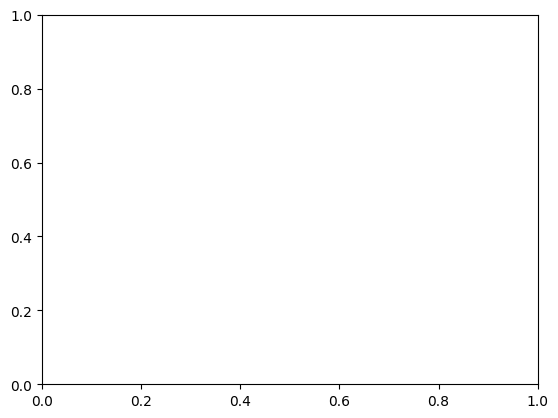

In [52]:
import matplotlib.pyplot as plt

tensor = df["decoded_tensor"].iloc[0]
if tensor is not None:
    plt.plot(tensor.numpy())
    plt.title("Decoded Tensor Values")
    plt.show()